# RESULTS DVS Gesture

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle, sys
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import apply_jitter, get_loader, get_sliced_loader, make_histogram_classification, HOTS_Dataset, fit_mlr, predict_mlr, score_classif_events, plotjitter, printfig, online_accuracy
import matplotlib.pyplot as plt
import numpy as np

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')
    
device = 'cuda'

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.2.1
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


In [3]:
import zipfile as z
from torchvision.datasets.vision import VisionDataset


class DVSGesture_dataset(VisionDataset):
    """DVSGesture <http://research.ibm.com/dvsgesture/> dataset, either reduced or foveated.
    arguments:
        repertory: root repertory where the different processed datasets are stored 
        type_data: must be either test (to load test data), reduce (to load reduced data) or fovea (to load foveated data)
        spatial_divider: spatial dividing factor (all data is divided by 4, no need to change default)
        structural_divider: structural dividing factor, to keep only a certain percentage of the processed data 
                    (if want to charge the whole processed data, set structural_divider to 100)
        method: spacial downscaling method 
                    (if type_data not 'test', roi_method must be either 'funnelling', 'eventcount', 'linear' or 'cubic')
        roi_method: ROI data to use during foveation 
                    if type_data is 'fovea' and roi is maintained to default None, then use data foveated on whole input data ; 
                    else, use data foveated on downscaled data using a certain method)
    """

    classes = [
        "hand_clapping",
        "right_hand_wave",
        "left_hand_wave",
        "right_arm_clockwise",
        "right_arm_counter_clockwise",
        "left_arm_clockwise",
        "left_arm_counter_clockwise",
        "arm_roll",
        "air_drums",
        "air_guitar",
        "other_gestures",
    ]

    sensor_size = (128, 128)
    ordering = "xypt"
    dtype = np.dtype([("x", np.int16), ("y", np.int16), ("p", bool), ("t", np.int64)])

    def __init__(
        self, repertory, type_data, spatial_divider=4, structural_divider=100, method=None, roi_method=None, 
    transform = tonic.transforms.NumpyAsType(int)):
        super(DVSGesture_dataset, self).__init__(repertory)
        assert type_data in ['test', 'reduce', 'fovea'], "Wrong 'type_data' argument"

        if type_data == 'test':
            self.zip_name = type_data
            self.folder_name = 'Test data/'
        
        elif type_data == 'reduce':
            assert method in ['funnelling', 'eventcount', 'linear', 'cubic'], "Wrong 'method' argument"
            self.zip_name = 'reduced_data_'+method+'_div'+str(spatial_divider)
            self.folder_name = 'Reduced data/Method - '+method+'/'
        
        else : 
            assert method in ['funnelling', 'eventcount', 'linear', 'cubic'], "Wrong 'method' argument"
            assert roi_method in ['funnelling', 'eventcount', 'linear', 'cubic', None], "Wrong 'roi_method' argument"
            
            if roi_method == None:
                roi_method = 'no reduc'
            self.folder_name = 'Foveated data/ROI data - '+roi_method+'/Method - '+method+'/'
            
            if roi_method == 'no reduc':
                roi_method = 'none'
            self.zip_name = 'foveated_data_'+method+'_div'+str(spatial_divider)+'_ROI'+roi_method

        if structural_divider != 100:
            assert structural_divider in [5,10,20,40,60,80], "Wrong 'structural_divider' argument"
            self.zip_name += '_'+str(structural_divider)+'%'

        self.location_on_system = repertory
        self.data = []
        self.samples = []
        self.targets = []
        #self.transform = transform

        file_path = os.path.join(self.location_on_system, self.folder_name, self.zip_name)
        
        if not os.path.exists(file_path) and os.path.exists(file_path+'.zip'):
            
            print('Extracting into '+file_path+'...')
            with z.ZipFile(file_path+'.zip', 'r') as zip_dir :
                zip_dir.extractall(os.path.join(self.location_on_system, self.folder_name))
            print('Extraction done')

        if os.path.exists(file_path):
    
            for path, dirs, files in os.walk(file_path):
                dirs.sort()
                for file in files:
                    if file.endswith("npy"):
                        self.samples.append(path + "/" + file)
                        self.targets.append(int(file[:-4]))

        else: 
            print('Error: The folder '+file_path+' does not exist')
            sys.exit()

    def __getitem__(self, index):
        events = np.load(self.samples[index])
        events[:, 3] *= 1000  # convert from ms to us
        target = self.targets[index]
        events = np.lib.recfunctions.unstructured_to_structured(events, self.dtype)
        if self.transform is not None:
            events = self.transform(events, self.sensor_size, self.ordering)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return events, target

    def __len__(self):
        return len(self.samples)

## Loading of the dataset for the clustering phase

In [4]:
kfold_test = None
kfold_clust = 10
ts_batch_size = 1000

dataset_name = 'gesture'
slicing_time_window = 1e6

type_transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.DVSGesture(save_to='../../Data/', train=True, transform=type_transform)
loader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_clust)
trainloader = get_sliced_loader(trainset, slicing_time_window, dataset_name, True, only_first=True, kfold=kfold_test)
num_sample_train = len(trainloader)
n_classes = len(trainset.classes)
print(f'number of samples in the training set: {len(trainloader)}')

../../Data/DVSGesture/metadata/gesture_1000_True_True
Metadata read from ../../Data/DVSGesture/metadata/gesture_1000_True_True/slice_metadata.h5.
../../Data/DVSGesture/metadata/gesture_1000_True_True
Metadata read from ../../Data/DVSGesture/metadata/gesture_1000_True_True/slice_metadata.h5.
number of samples in the training set: 1077


## Initialization of the network

In [5]:
name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'gesture'

Rz = [4, 8]
N_neuronz = [16, 32]
tauz = [5e4*2, 5e4*16]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, device = device)

initial_name = hots.name

## Unsupervised clustering

In [6]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold = filtering_threshold, device = device)

## Training of the classification layer

In [7]:
jitter = (None, None)
num_workers = 0
learning_rate = 0.0001
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 11#2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
tau_cla = 1e8
drop_proba = .99

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
model_path = f'../Records/networks/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
print(model_path)

hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, device = device, ts_batch_size = ts_batch_size, verbose=False)

drop_transform = tonic.transforms.DropEvent(p = drop_proba)
kfold_mlr = None

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=tonic.transforms.Compose([drop_transform, type_transform]))
trainoutputloader = get_loader(trainset_output)

classif_layer, losses = fit_mlr(trainoutputloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes), ts_batch_size = ts_batch_size, device = device)

../Records/networks/2022-04-22_gesture_homeohots_True_[16, 32]_[100000.0, 800000.0]_[4, 8]_100000000.0_0.0001_(0.9, 0.999)_11_0.99_(None, None).pkl


../../Data/DVSGesture/metadata/gesture_1000_True_False
Metadata read from ../../Data/DVSGesture/metadata/gesture_1000_True_False/slice_metadata.h5.
Number of chance decisions: 0
90th quantile for number of events: 106517.5
Mean accuracy: 72.39999999999999%
Last accuracy: 75.8%
Highest probability accuracy: 78.8%


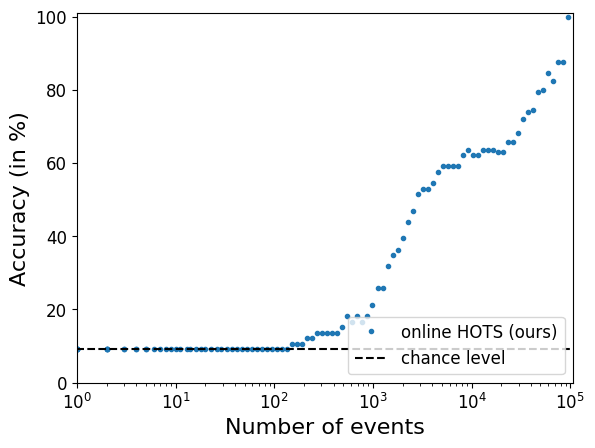

In [8]:
testset = tonic.datasets.DVSGesture(save_to='../../Data/', train=False, transform=type_transform)
testloader = get_sliced_loader(testset, slicing_time_window, dataset_name, False, only_first=True, kfold=kfold_test)
hots.coding(testloader, trainset.ordering, trainset.classes, filtering_threshold = filtering_threshold, training=False, ts_batch_size = ts_batch_size, verbose=False)
num_sample_test = len(testloader)
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=testset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

mlr_threshold = None
onlinac = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

## Reduced datasets
### Cubic

In [9]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'reduce'
method = 'cubic'
roi_method = None

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = ts_batch_size, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

Metadata read from ../../Data/DVSGesture_reduced/Reduced data/Method - cubic/metadata/slice_metadata.h5.
number of samples in the testing set: 264


Number of chance decisions: 39
90th quantile for number of events: 33598.3
Mean accuracy: 8.5%
Last accuracy: 12.9%
Highest probability accuracy: 12.5%


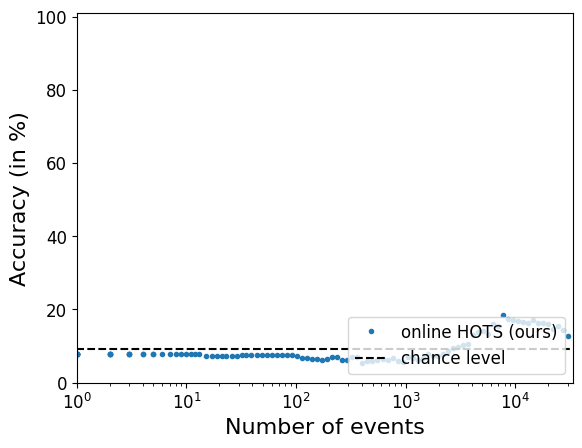

In [10]:
mlr_threshold = None
onlinac_reduce_cubic,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

In [11]:
print(test_path)

../Records/output/test/2022-04-22_gesture_homeohots_True_[16, 32]_[100000.0, 800000.0]_[4, 8]_reduce_cubic_264_(None, None)/


### Linear

In [12]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'reduce'
method = 'linear'
roi_method = None

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = ts_batch_size, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

Metadata read from ../../Data/DVSGesture_reduced/Reduced data/Method - linear/metadata/slice_metadata.h5.
number of samples in the testing set: 264


Number of chance decisions: 59
90th quantile for number of events: 31773.60000000003
Mean accuracy: 14.899999999999999%
Last accuracy: 18.2%
Highest probability accuracy: 14.000000000000002%


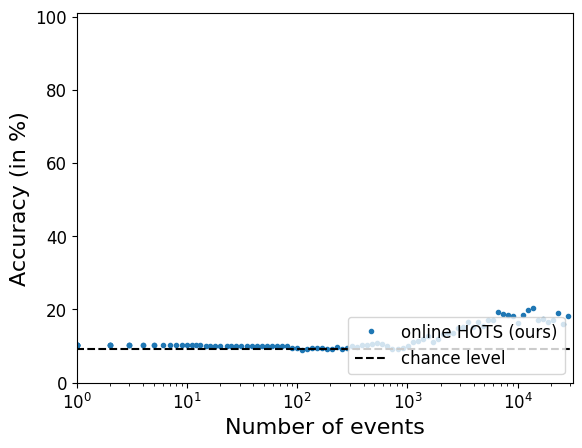

In [13]:
mlr_threshold = None
onlinac_reduce_linear,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

### Event count

In [14]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'reduce'
method = 'eventcount'
roi_method = None

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = ts_batch_size, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

Metadata read from ../../Data/DVSGesture_reduced/Reduced data/Method - eventcount/metadata/slice_metadata.h5.
number of samples in the testing set: 264


Number of chance decisions: 0
90th quantile for number of events: 92414.90000000001
Mean accuracy: 51.300000000000004%
Last accuracy: 62.9%
Highest probability accuracy: 58.699999999999996%


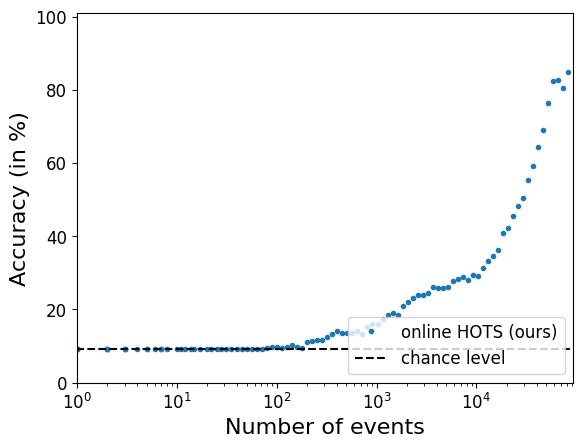

In [15]:
mlr_threshold = None
onlinac_reduce_eventcount,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

### Funnelling

In [16]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'reduce'
method = 'funnelling'
roi_method = None

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = ts_batch_size, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

Metadata read from ../../Data/DVSGesture_reduced/Reduced data/Method - funnelling/metadata/slice_metadata.h5.
number of samples in the testing set: 264


In [ ]:
mlr_threshold = None
onlinac_reduce_funnelling,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

  2%|██▌                                                                                                                                       | 5/264 [1:03:55<66:26:20, 923.48s/it]

## Foveated datasets
### Cubic

In [ ]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'fovea'
method = 'cubic'
roi_method = 'cubic'

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = ts_batch_size, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

In [ ]:
mlr_threshold = None
onlinac_fovea_funnelling,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

### Linear

In [ ]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'fovea'
method = 'linear'
roi_method = 'linear'

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = ts_batch_size, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

In [ ]:
mlr_threshold = None
onlinac_fovea_funnelling,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

### Event count

In [ ]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'fovea'
method = 'eventcount'
roi_method = 'eventcount'

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = ts_batch_size, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

In [ ]:
mlr_threshold = None
onlinac_fovea_funnelling,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)

### Funnelling

In [ ]:
repertory = '../../Data/DVSGesture_reduced'
type_data = 'foveated'
method = 'funnelling'
roi_method = None

hots.name = initial_name+'_'+type_data+'_'+method

testset = DVSGesture_dataset(repertory, type_data, spatial_divider=4, structural_divider=100, method=method, roi_method=roi_method)
metadata_path = testset.location_on_system+'/'+testset.folder_name+'metadata'
slicer = tonic.slicers.SliceAtTimePoints(start_tw = [0], end_tw = [slicing_time_window])
sliced_dataset = tonic.SlicedDataset(testset, slicer = slicer, transform = type_transform, metadata_path = metadata_path)
testloader = torch.utils.data.DataLoader(sliced_dataset, shuffle=False, num_workers = num_workers)
num_sample_test = len(sliced_dataset)
classes = sliced_dataset.dataset.classes
targets = sliced_dataset.dataset.targets
print(f'number of samples in the testing set: {len(testloader)}')
hots.coding(testloader, trainset.ordering, trainset.classes, training=False, device = device, ts_batch_size = None, verbose=False)

test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'
results_path = f'../Records/LR_results/{hots.name}_{tau_cla}_{learning_rate}_{betas}_{num_epochs}_{drop_proba}_{jitter}.pkl'
testset_output = HOTS_Dataset(test_path, testset.sensor_size, testset.classes, dtype=trainset.dtype, transform=type_transform)
testoutputloader = get_loader(testset_output)

In [ ]:
mlr_threshold = None
onlinac_fovea_funnelling,_,_,_ = online_accuracy(classif_layer, tau_cla, testoutputloader, results_path, ts_size, testset_output.ordering, n_classes, mlr_threshold = mlr_threshold, ts_batch_size = ts_batch_size, online_plot=True)